In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_excel('./data/train_clientes.xlsx', index_col='ID_CORRELATIVO')
df_test = pd.read_excel('./data/test_clientes.xlsx', index_col='ID_CORRELATIVO')
df_train_req = pd.read_excel('./data/train_requerimientos.xlsx', index_col='ID_CORRELATIVO')
df_test_req = pd.read_excel('./data/test_requerimientos.xlsx', index_col='ID_CORRELATIVO')

## Data Clientes

In [9]:
x_train = df_train.drop(['ATTRITION'], axis=1)
y_train = df_train['ATTRITION']
x_test = df_test

In [10]:
# Join train and test df to aplly feature engineering
df = pd.concat([x_train, x_test])
print df.shape

(100000, 51)


In [11]:
# Split columns by type
num_cols = df.select_dtypes(exclude=['datetime', 'object']).columns.tolist()
cat_cols = [col for col in df.columns if col not in num_cols]

In [12]:
df[cat_cols].describe(include=['object'])

,RANG_INGRESO,FLAG_LIMA_PROVINCIA,RANG_SDO_PASIVO_MENOS0,RANG_NRO_PRODUCTOS_MENOS0
count,86445,95101,100000,100000
unique,9,2,15,6
top,Rang_ingreso_01,Lima,Rango_SDO_01,Rango_02
freq,22019,59549,39013,53222


In [13]:
# Categ feat 1
df[cat_cols[0]] = df[cat_cols[0]].apply(lambda x: int(x[-1]) if pd.isnull(x) == False else x)

In [14]:
# Categ feat 2
df = pd.concat([df, pd.get_dummies(df[cat_cols[1]], prefix='FLAG')], axis=1)
df.drop(cat_cols[1], inplace=True, axis=1)
df.head()

,CODMES,FLG_BANCARIZADO,RANG_INGRESO,EDAD,ANTIGUEDAD,RANG_SDO_PASIVO_MENOS0,SDO_ACTIVO_MENOS0,SDO_ACTIVO_MENOS1,SDO_ACTIVO_MENOS2,SDO_ACTIVO_MENOS3,...,NRO_ENTID_SSFF_MENOS4,NRO_ENTID_SSFF_MENOS5,FLG_SDO_OTSSFF_MENOS0,FLG_SDO_OTSSFF_MENOS1,FLG_SDO_OTSSFF_MENOS2,FLG_SDO_OTSSFF_MENOS3,FLG_SDO_OTSSFF_MENOS4,FLG_SDO_OTSSFF_MENOS5,FLAG_Lima,FLAG_Provincia
ID_CORRELATIVO,,,,,,,,,,,,,,,,,,,,,
35653,201208,1,6.0,25.0,6.0,Rango_SDO_09,0,0,0,0,...,1,1,1,0,0,0,0,0,1,0
66575,201208,1,3.0,27.0,0.0,Rango_SDO_01,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
56800,201208,1,1.0,34.0,4.0,Rango_SDO_02,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8410,201208,1,4.0,63.0,5.0,Rango_SDO_03,0,0,0,0,...,3,3,1,1,1,1,1,1,0,1
6853,201208,1,NaN,25.0,0.0,Rango_SDO_01,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
# Categ feat 3
df[cat_cols[2]] = df[cat_cols[2]].apply(lambda x: int(x[-1]) if x != 'Cero' else 0)

In [16]:
# Categ feat 4
df[cat_cols[3]] = df[cat_cols[3]].apply(lambda x: int(x[-1])) 

In [17]:
# Drop CODMES
df.drop('CODMES', inplace=True, axis=1)
cat_cols.remove(cat_cols[1])

## Data requerimientos

In [18]:
df_train_req.isnull().sum()

TIPO_REQUERIMIENTO2    0
DICTAMEN               1
CODMES                 0
PRODUCTO_SERVICIO_2    0
SUBMOTIVO_2            0
dtype: int64

In [19]:
df_train_req.fillna(-999, inplace=True)

## Modelado clientes

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [21]:
x_train_ = df.iloc[0:70000]
x_test_ = df.iloc[70000:]

xtrain, xtest, ytrain, ytest = train_test_split(x_train_, y_train, test_size=.10, random_state=1234)

### XGBoost

In [23]:
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dtest = xgb.DMatrix(xtest, label=ytest)

params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta':.1,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'binary:logistic',
    'eval_metric':'logloss'
}

xgb_model = xgb.train(params, 
                      dtrain,
                      num_boost_round=999, 
                      early_stopping_rounds=10,
                      evals=[(dtest, "Test")])

[0]	Test-logloss:0.636008
Will train until Test-logloss hasn't improved in 10 rounds.
[1]	Test-logloss:0.589358
[2]	Test-logloss:0.550694
[3]	Test-logloss:0.518002
[4]	Test-logloss:0.490682
[5]	Test-logloss:0.467152
[6]	Test-logloss:0.447266
[7]	Test-logloss:0.430198
[8]	Test-logloss:0.415296
[9]	Test-logloss:0.402457
[10]	Test-logloss:0.391078
[11]	Test-logloss:0.381468
[12]	Test-logloss:0.373063
[13]	Test-logloss:0.365614
[14]	Test-logloss:0.359031
[15]	Test-logloss:0.353518
[16]	Test-logloss:0.348495
[17]	Test-logloss:0.343351
[18]	Test-logloss:0.339345
[19]	Test-logloss:0.336018
[20]	Test-logloss:0.333084
[21]	Test-logloss:0.33053
[22]	Test-logloss:0.328229
[23]	Test-logloss:0.326168
[24]	Test-logloss:0.324255
[25]	Test-logloss:0.322663
[26]	Test-logloss:0.321173
[27]	Test-logloss:0.319764
[28]	Test-logloss:0.318417
[29]	Test-logloss:0.317365
[30]	Test-logloss:0.316329
[31]	Test-logloss:0.315713
[32]	Test-logloss:0.3149
[33]	Test-logloss:0.314108
[34]	Test-logloss:0.313314
[35]	Tes

In [24]:
xgb.cv(params, 
       dtrain, 
       num_boost_round=999,
       early_stopping_rounds=10, 
       nfold=5, 
       seed=1234,
       metrics='logloss')

,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std
0,0.636651,0.000478,0.636391,0.000200
1,0.590434,0.000920,0.589910,0.000397
2,0.551944,0.001295,0.551200,0.000622
3,0.519739,0.001789,0.518777,0.000689
4,0.492374,0.002026,0.491155,0.000867
5,0.469339,0.002400,0.467871,0.000957
6,0.449539,0.002817,0.447748,0.000964
7,0.432359,0.003118,0.430344,0.001027
8,0.417612,0.003440,0.415332,0.001122
9,0.404756,0.003759,0.402283,0.001176


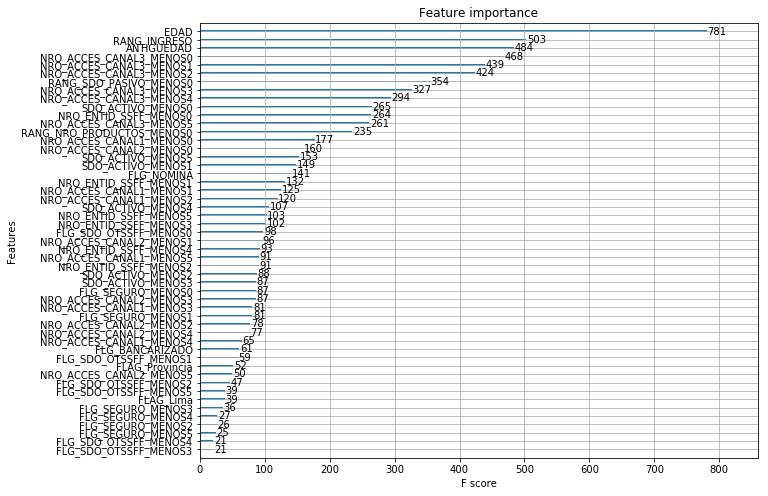

In [25]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, height=0.2, ax=ax)

In [41]:
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV 

def modelfit(alg, xtrain, ytrain, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xtrain, label=ytrain)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xtrain, ytrain, eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(xtrain)
    dtrain_predprob = alg.predict_proba(xtrain)[:,1]
    
    mean_logloss = cvresult['test-logloss-mean'].min()
    boost_rounds = cvresult.shape[0]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(ytrain, dtrain_predictions)
    print "Logloss (Train): %f" % metrics.log_loss(ytrain, dtrain_predprob)
    print "Logloss (CV): %f" % mean_logloss
    print "Rounds (CV): {}".format(boost_rounds) 
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8833
Logloss (Train): 0.281220
Logloss (CV): 0.306216
Rounds (CV): 171.000000


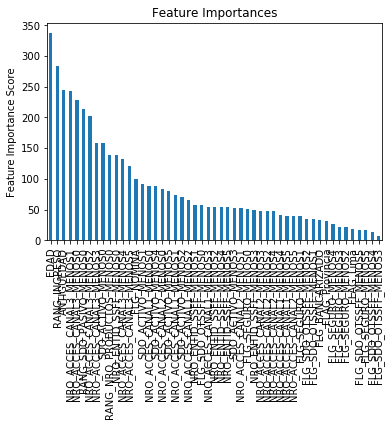

In [40]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=1234
)

modelfit(xgb1, xtrain, ytrain)

In [45]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(
    estimator=XGBClassifier(learning_rate =0.1, 
                            n_estimators=171, 
                            max_depth=5,
                            min_child_weight=1, 
                            gamma=0, 
                            subsample=0.8, 
                            colsample_bytree=0.8,
                            objective='binary:logistic', 
                            nthread=-1, 
                            scale_pos_weight=1, 
                            seed=1234), 
    param_grid = param_test1, 
    scoring='neg_log_loss',
    n_jobs=-1,
    iid=False, 
    cv=5
)

gsearch1.fit(xtrain, ytrain)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=171, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='neg_log_loss',
       verbose=0)

([mean: -0.31470, std: 0.00123, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.31465, std: 0.00138, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.31449, std: 0.00139, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.30664, std: 0.00220, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.30656, std: 0.00220, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.30668, std: 0.00191, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.30435, std: 0.00246, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.30423, std: 0.00230, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.30378, std: 0.00257, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.30807, std: 0.00230, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.30527, std: 0.00220, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.30454, std: 0.00271, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_chil

In [46]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(
    estimator=XGBClassifier(learning_rate=0.1, 
                            n_estimators=171, 
                            max_depth=7,
                            min_child_weight=5, 
                            gamma=0, 
                            subsample=0.8, 
                            colsample_bytree=0.8,
                            objective='binary:logistic', 
                            nthread=-1, 
                            scale_pos_weight=1, 
                            seed=1234), 
    param_grid = param_test3, 
    scoring='neg_log_loss',
    n_jobs=-1,
    iid=False, 
    cv=5
)

gsearch3.fit(xtrain, ytrain)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=171, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='neg_log_loss',
       verbose=0)

([mean: -0.30378, std: 0.00257, params: {'gamma': 0.0},
  mean: -0.30418, std: 0.00230, params: {'gamma': 0.1},
  mean: -0.30446, std: 0.00231, params: {'gamma': 0.2},
  mean: -0.30393, std: 0.00263, params: {'gamma': 0.3},
  mean: -0.30400, std: 0.00254, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -0.30377924302772963)


Model Report
Accuracy : 0.8893
Logloss (Train): 0.266644
Logloss (CV): 0.303301
Rounds (CV): 125


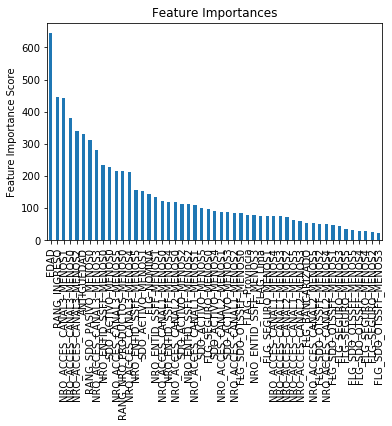

In [47]:
xgb2 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=7,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=1234)

modelfit(xgb2, xtrain, ytrain)

In [48]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(
    estimator=XGBClassifier(learning_rate=0.1, 
                            n_estimators=125, 
                            max_depth=7,
                            min_child_weight=5, 
                            gamma=0, 
                            subsample=0.8, 
                            colsample_bytree=0.8,
                            objective='binary:logistic', 
                            nthread=-1, 
                            scale_pos_weight=1, 
                            seed=1234), 
    param_grid = param_test4, 
    scoring='neg_log_loss',
    n_jobs=-1,
    iid=False, 
    cv=5
)

gsearch4.fit(xtrain, ytrain)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=125, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='neg_log_loss',
       verbose=0)

([mean: -0.30499, std: 0.00261, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -0.30404, std: 0.00256, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -0.30429, std: 0.00205, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -0.30339, std: 0.00233, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: -0.30479, std: 0.00223, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -0.30453, std: 0.00263, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -0.30388, std: 0.00154, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -0.30364, std: 0.00242, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -0.30487, std: 0.00189, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: -0.30412, std: 0.00236, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: -0.30416, std: 0.00228, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: -0.30372, std: 0.00191, params: {'subsample': 0.9, 'colsa

In [49]:
param_test5 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch5 = GridSearchCV(
    estimator=XGBClassifier(learning_rate=0.1, 
                            n_estimators=125, 
                            max_depth=7,
                            min_child_weight=5, 
                            gamma=0, 
                            subsample=0.9, 
                            colsample_bytree=0.6,
                            objective='binary:logistic', 
                            nthread=-1, 
                            scale_pos_weight=1, 
                            seed=1234), 
    param_grid = param_test5, 
    scoring='neg_log_loss',
    n_jobs=-1,
    iid=False, 
    cv=5
)

gsearch5.fit(xtrain, ytrain)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=125, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.9),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='neg_log_loss',
       verbose=0)

([mean: -0.30339, std: 0.00233, params: {'reg_alpha': 1e-05},
  mean: -0.30341, std: 0.00240, params: {'reg_alpha': 0.01},
  mean: -0.30359, std: 0.00211, params: {'reg_alpha': 0.1},
  mean: -0.30328, std: 0.00207, params: {'reg_alpha': 1},
  mean: -0.31829, std: 0.00135, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 -0.3032800627287042)


Model Report
Accuracy : 0.8892
Logloss (Train): 0.266387
Logloss (CV): 0.302755
Rounds (CV): 138


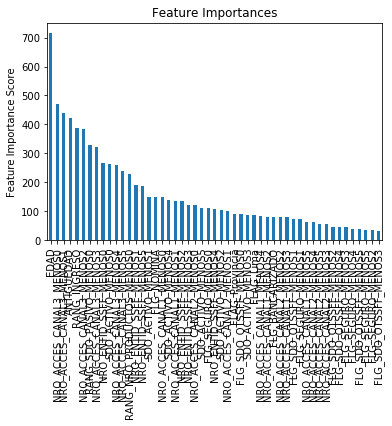

In [50]:
xgb3 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=7,
    min_child_weight=5,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.6,
    reg_alpha=1,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=1234)
modelfit(xgb3, xtrain, ytrain)


Model Report
Accuracy : 0.8884
Logloss (Train): 0.268573
Logloss (CV): 0.301798
Rounds (CV): 1290


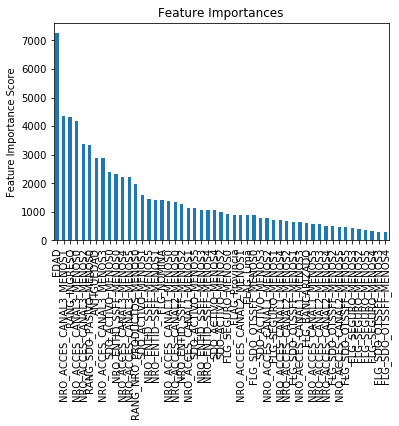

In [51]:
xgb4 = XGBClassifier(
    learning_rate=0.01,
    n_estimators=5000,
    max_depth=7,
    min_child_weight=5,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.6,
    reg_alpha=1,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=1234)
modelfit(xgb4, xtrain, ytrain)

In [52]:
best_xgb = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1290,
    max_depth=7,
    min_child_weight=5,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.6,
    reg_alpha=1,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=1234)

best_xgb.fit(xtrain, ytrain, eval_metric='logloss')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=1290, nthread=-1,
       objective='binary:logistic', reg_alpha=1, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.9)

In [57]:
y_pred = best_xgb.predict_proba(x_test_)[:,1]
submission = pd.DataFrame()
submission['ID_CORRELATIVO'] = x_test.index
submission['ATTRITION'] = y_pred
submission.head()

submission.to_csv('./data/submission11.csv', index=False)

,ID_CORRELATIVO,ATTRITION
0,47411,0.319422
1,39861,0.331425
2,38898,0.023454
3,50927,0.017122
4,32969,0.341649


In [29]:
gridsearch_params = [(max_depth, min_child_weight)
                    for max_depth in range(9,12)
                    for min_child_weight in range(5,8)]

min_logloss = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics='logloss',
        early_stopping_rounds=10
    )

    # Update best logloss
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth, min_child_weight)

print("Best params: {}, {}, Logloss: {}".format(best_params[0], best_params[1], min_logloss))

CV with max_depth=9, min_child_weight=5
	Logloss 0.3040202 for 19 rounds
CV with max_depth=9, min_child_weight=6
	Logloss 0.3036528 for 22 rounds
CV with max_depth=9, min_child_weight=7
	Logloss 0.3044032 for 21 rounds
CV with max_depth=10, min_child_weight=5
	Logloss 0.3049842 for 17 rounds
CV with max_depth=10, min_child_weight=6
	Logloss 0.3034432 for 19 rounds
CV with max_depth=10, min_child_weight=7
	Logloss 0.3039724 for 24 rounds
CV with max_depth=11, min_child_weight=5
	Logloss 0.3047202 for 19 rounds
CV with max_depth=11, min_child_weight=6
	Logloss 0.3043126 for 15 rounds
CV with max_depth=11, min_child_weight=7
	Logloss 0.3040838 for 18 rounds
Best params: 10, 6, Logloss: 0.3034432


In [31]:
params['max_depth'] = 10
params['min_child_weight'] = 6

In [32]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_logloss = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics='logloss',
        early_stopping_rounds=10
    )

    # Update best logloss
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (subsample, colsample)

print("Best params: {}, {}, Logloss: {}".format(best_params[0], best_params[1], min_logloss))

CV with subsample=1.0, colsample=1.0
	Logloss 0.3034432 for 19 rounds
CV with subsample=1.0, colsample=0.9
	Logloss 0.3039438 for 17 rounds
CV with subsample=1.0, colsample=0.8
	Logloss 0.303195 for 20 rounds
CV with subsample=1.0, colsample=0.7
	Logloss 0.303581 for 24 rounds
CV with subsample=0.9, colsample=1.0
	Logloss 0.3045924 for 18 rounds
CV with subsample=0.9, colsample=0.9
	Logloss 0.3039564 for 17 rounds
CV with subsample=0.9, colsample=0.8
	Logloss 0.3039918 for 18 rounds
CV with subsample=0.9, colsample=0.7
	Logloss 0.3038966 for 19 rounds
CV with subsample=0.8, colsample=1.0
	Logloss 0.303843 for 17 rounds
CV with subsample=0.8, colsample=0.9
	Logloss 0.3043816 for 18 rounds
CV with subsample=0.8, colsample=0.8
	Logloss 0.3043962 for 19 rounds
CV with subsample=0.8, colsample=0.7
	Logloss 0.3053458 for 19 rounds
CV with subsample=0.7, colsample=1.0
	Logloss 0.3058068 for 15 rounds
CV with subsample=0.7, colsample=0.9
	Logloss 0.3041872 for 15 rounds
CV with subsample=0.7, 

In [33]:
params['subsample'] = 1.0
params['colsample'] = 0.8

In [34]:
min_logloss = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

    # We update our parameters
    params['eta'] = eta
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics='logloss',
        early_stopping_rounds=10
    )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = eta

print("Best params: {}, Logloss: {}".format(best_params, min_logloss))

CV with eta=0.3
	Logloss 0.303581 for 24 rounds
CV with eta=0.2
	Logloss 0.3020758 for 30 rounds
CV with eta=0.1
	Logloss 0.300881 for 73 rounds
CV with eta=0.05
	Logloss 0.3001724 for 136 rounds
CV with eta=0.01
	Logloss 0.2996782 for 693 rounds
CV with eta=0.005
	Logloss 0.3003636 for 998 rounds
Best params: 0.01, Logloss: 0.2996782


In [35]:
params['eta'] = 0.01

In [38]:
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-logloss:0.687377
Will train until Test-logloss hasn't improved in 10 rounds.
[1]	Test-logloss:0.681775
[2]	Test-logloss:0.675767
[3]	Test-logloss:0.670176
[4]	Test-logloss:0.664502
[5]	Test-logloss:0.658899
[6]	Test-logloss:0.65344
[7]	Test-logloss:0.648727
[8]	Test-logloss:0.643662
[9]	Test-logloss:0.638418
[10]	Test-logloss:0.633217
[11]	Test-logloss:0.628204
[12]	Test-logloss:0.623293
[13]	Test-logloss:0.618387
[14]	Test-logloss:0.613595
[15]	Test-logloss:0.60889
[16]	Test-logloss:0.604896
[17]	Test-logloss:0.600896
[18]	Test-logloss:0.596385
[19]	Test-logloss:0.591937
[20]	Test-logloss:0.587573
[21]	Test-logloss:0.583586
[22]	Test-logloss:0.579448
[23]	Test-logloss:0.575914
[24]	Test-logloss:0.572152
[25]	Test-logloss:0.568488
[26]	Test-logloss:0.564794
[27]	Test-logloss:0.560863
[28]	Test-logloss:0.557302
[29]	Test-logloss:0.553562
[30]	Test-logloss:0.550129
[31]	Test-logloss:0.546712
[32]	Test-logloss:0.543092
[33]	Test-logloss:0.539872
[34]	Test-logloss:0.536688
[35]	Te

[296]	Test-logloss:0.304981
[297]	Test-logloss:0.304827
[298]	Test-logloss:0.304737
[299]	Test-logloss:0.304623
[300]	Test-logloss:0.304502
[301]	Test-logloss:0.304392
[302]	Test-logloss:0.30426
[303]	Test-logloss:0.304111
[304]	Test-logloss:0.303957
[305]	Test-logloss:0.303802
[306]	Test-logloss:0.30367
[307]	Test-logloss:0.303517
[308]	Test-logloss:0.303441
[309]	Test-logloss:0.303292
[310]	Test-logloss:0.3032
[311]	Test-logloss:0.303067
[312]	Test-logloss:0.302952
[313]	Test-logloss:0.302825
[314]	Test-logloss:0.302704
[315]	Test-logloss:0.302569
[316]	Test-logloss:0.302454
[317]	Test-logloss:0.302345
[318]	Test-logloss:0.302252
[319]	Test-logloss:0.302105
[320]	Test-logloss:0.302049
[321]	Test-logloss:0.301972
[322]	Test-logloss:0.301871
[323]	Test-logloss:0.301791
[324]	Test-logloss:0.301672
[325]	Test-logloss:0.30154
[326]	Test-logloss:0.301451
[327]	Test-logloss:0.301389
[328]	Test-logloss:0.301307
[329]	Test-logloss:0.301197
[330]	Test-logloss:0.301069
[331]	Test-logloss:0.3009

[590]	Test-logloss:0.292957
[591]	Test-logloss:0.292954
[592]	Test-logloss:0.292952
[593]	Test-logloss:0.292956
[594]	Test-logloss:0.29296
[595]	Test-logloss:0.29296
[596]	Test-logloss:0.292956
[597]	Test-logloss:0.292959
[598]	Test-logloss:0.29295
[599]	Test-logloss:0.292945
[600]	Test-logloss:0.292949
[601]	Test-logloss:0.292962
[602]	Test-logloss:0.292963
[603]	Test-logloss:0.29296
[604]	Test-logloss:0.292966
[605]	Test-logloss:0.292964
[606]	Test-logloss:0.292965
[607]	Test-logloss:0.292965
[608]	Test-logloss:0.292959
[609]	Test-logloss:0.292955
Stopping. Best iteration:
[599]	Test-logloss:0.292945



In [40]:
best_xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=xgb_model.best_iteration+1,
    evals=[(dtest, "Test")]
)

[0]	Test-logloss:0.687377
[1]	Test-logloss:0.681775
[2]	Test-logloss:0.675767
[3]	Test-logloss:0.670176
[4]	Test-logloss:0.664502
[5]	Test-logloss:0.658899
[6]	Test-logloss:0.65344
[7]	Test-logloss:0.648727
[8]	Test-logloss:0.643662
[9]	Test-logloss:0.638418
[10]	Test-logloss:0.633217
[11]	Test-logloss:0.628204
[12]	Test-logloss:0.623293
[13]	Test-logloss:0.618387
[14]	Test-logloss:0.613595
[15]	Test-logloss:0.60889
[16]	Test-logloss:0.604896
[17]	Test-logloss:0.600896
[18]	Test-logloss:0.596385
[19]	Test-logloss:0.591937
[20]	Test-logloss:0.587573
[21]	Test-logloss:0.583586
[22]	Test-logloss:0.579448
[23]	Test-logloss:0.575914
[24]	Test-logloss:0.572152
[25]	Test-logloss:0.568488
[26]	Test-logloss:0.564794
[27]	Test-logloss:0.560863
[28]	Test-logloss:0.557302
[29]	Test-logloss:0.553562
[30]	Test-logloss:0.550129
[31]	Test-logloss:0.546712
[32]	Test-logloss:0.543092
[33]	Test-logloss:0.539872
[34]	Test-logloss:0.536688
[35]	Test-logloss:0.533235
[36]	Test-logloss:0.53019
[37]	Test-logl

[298]	Test-logloss:0.304737
[299]	Test-logloss:0.304623
[300]	Test-logloss:0.304502
[301]	Test-logloss:0.304392
[302]	Test-logloss:0.30426
[303]	Test-logloss:0.304111
[304]	Test-logloss:0.303957
[305]	Test-logloss:0.303802
[306]	Test-logloss:0.30367
[307]	Test-logloss:0.303517
[308]	Test-logloss:0.303441
[309]	Test-logloss:0.303292
[310]	Test-logloss:0.3032
[311]	Test-logloss:0.303067
[312]	Test-logloss:0.302952
[313]	Test-logloss:0.302825
[314]	Test-logloss:0.302704
[315]	Test-logloss:0.302569
[316]	Test-logloss:0.302454
[317]	Test-logloss:0.302345
[318]	Test-logloss:0.302252
[319]	Test-logloss:0.302105
[320]	Test-logloss:0.302049
[321]	Test-logloss:0.301972
[322]	Test-logloss:0.301871
[323]	Test-logloss:0.301791
[324]	Test-logloss:0.301672
[325]	Test-logloss:0.30154
[326]	Test-logloss:0.301451
[327]	Test-logloss:0.301389
[328]	Test-logloss:0.301307
[329]	Test-logloss:0.301197
[330]	Test-logloss:0.301069
[331]	Test-logloss:0.300956
[332]	Test-logloss:0.300839
[333]	Test-logloss:0.3007

[592]	Test-logloss:0.292952
[593]	Test-logloss:0.292956
[594]	Test-logloss:0.29296
[595]	Test-logloss:0.29296
[596]	Test-logloss:0.292956
[597]	Test-logloss:0.292959
[598]	Test-logloss:0.29295
[599]	Test-logloss:0.292945


In [41]:
best_xgb_model.predict(xgb.DMatrix(x_test_))

array([ 0.29146487,  0.26989126,  0.02819077, ...,  0.09496684,
        0.23923253,  0.06652175], dtype=float32)

In [85]:
y_pred = best_xgb_model.predict(xgb.DMatrix(x_test_))
submission = pd.DataFrame()
submission['ID_CORRELATIVO'] = x_test_.index
submission['ATTRITION'] = y_pred
submission.head()

submission.to_csv('./data/submission10.csv', index=False)

,ID_CORRELATIVO,ATTRITION
0,47411,0.291465
1,39861,0.269891
2,38898,0.028191
3,50927,0.019253
4,32969,0.470753


### LightGBM

In [94]:
# Lightgbm

dtrain =lgb.Dataset(xtrain,label=ytrain)
dtest = lgb.Dataset(xtest,label=ytest)

params = {'objective': 'binary',
          'max_depth': 7,
          'learning_rate': .01,
          'colsample_bytree': 0.6, 
          'max_bin': 200,
          'metric': 'binary_logloss',
          'reg_alpha': 1,
          'reg_lambda': 1,
          'is_unbalanced': True}


lgb_model = lgb.train(params,
                      dtrain,
                      num_boost_round=999,
                      early_stopping_rounds=10,
                      valid_sets=[dtest, dtrain],
                      valid_names=["Test", "Train"]
                      )

[1]	Train's binary_logloss: 0.636416	Test's binary_logloss: 0.63591
Training until validation scores don't improve for 10 rounds.
[2]	Train's binary_logloss: 0.589956	Test's binary_logloss: 0.589104
[3]	Train's binary_logloss: 0.551479	Test's binary_logloss: 0.550381
[4]	Train's binary_logloss: 0.518884	Test's binary_logloss: 0.517617
[5]	Train's binary_logloss: 0.49156	Test's binary_logloss: 0.490271
[6]	Train's binary_logloss: 0.468133	Test's binary_logloss: 0.466725
[7]	Train's binary_logloss: 0.448289	Test's binary_logloss: 0.446749
[8]	Train's binary_logloss: 0.430993	Test's binary_logloss: 0.42967
[9]	Train's binary_logloss: 0.416037	Test's binary_logloss: 0.414689
[10]	Train's binary_logloss: 0.403169	Test's binary_logloss: 0.401921
[11]	Train's binary_logloss: 0.392029	Test's binary_logloss: 0.390791
[12]	Train's binary_logloss: 0.382581	Test's binary_logloss: 0.381114
[13]	Train's binary_logloss: 0.373894	Test's binary_logloss: 0.372679
[14]	Train's binary_logloss: 0.365792	Te

[120]	Train's binary_logloss: 0.283065	Test's binary_logloss: 0.302107
[121]	Train's binary_logloss: 0.282917	Test's binary_logloss: 0.302131
[122]	Train's binary_logloss: 0.282746	Test's binary_logloss: 0.302128
[123]	Train's binary_logloss: 0.282431	Test's binary_logloss: 0.302069
[124]	Train's binary_logloss: 0.282135	Test's binary_logloss: 0.302191
[125]	Train's binary_logloss: 0.281969	Test's binary_logloss: 0.302213
[126]	Train's binary_logloss: 0.281644	Test's binary_logloss: 0.302157
[127]	Train's binary_logloss: 0.281438	Test's binary_logloss: 0.302091
[128]	Train's binary_logloss: 0.281391	Test's binary_logloss: 0.302069
[129]	Train's binary_logloss: 0.281363	Test's binary_logloss: 0.302089
[130]	Train's binary_logloss: 0.281305	Test's binary_logloss: 0.302081
[131]	Train's binary_logloss: 0.281123	Test's binary_logloss: 0.302009
[132]	Train's binary_logloss: 0.280827	Test's binary_logloss: 0.301911
[133]	Train's binary_logloss: 0.280382	Test's binary_logloss: 0.301765
[134]	

In [95]:
lgb.cv(params,
       dtrain,
       nfold=5,
       num_boost_round=999,
       early_stopping_rounds=10,
       seed=1234)

{u'binary_logloss-mean': [0.63653929034174694,
  0.59029069571150328,
  0.55179443806063733,
  0.5193599685379795,
  0.49218521222879119,
  0.46888483075201026,
  0.44899726467063134,
  0.43193268672813118,
  0.41707114958847091,
  0.40428770667663205,
  0.39328082731307118,
  0.38377695385276472,
  0.37538773502544986,
  0.36807036415699618,
  0.3616333801761159,
  0.35576138435945504,
  0.35103135611155029,
  0.34656288627428689,
  0.3426791726682859,
  0.33953044820490319,
  0.33658220467621514,
  0.33387909454592762,
  0.33155084447723626,
  0.32938132342721582,
  0.32769994651002449,
  0.32607531754828606,
  0.32458186243019449,
  0.32333748048070687,
  0.3221880861956079,
  0.32114444676739851,
  0.32027913936848862,
  0.31943755683998232,
  0.31864867071682051,
  0.31787966414013474,
  0.3173370530291455,
  0.31672370801143052,
  0.31627707632437235,
  0.31572453344083135,
  0.31517006527790836,
  0.31477238733245555,
  0.31431581969949512,
  0.31395867982290826,
  0.31358754230

In [96]:
# Catboost

cat_index = np.where(xtrain.dtypes != np.int64)[0]
xtrain_ = xtrain.fillna(-999)
xtest_ = xtest.fillna(-999)

cat = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='Logloss')
cat.fit(xtrain_, ytrain, cat_features=cat_index, eval_set=(xtest_, ytest))

0:	learn: 0.6098000	test: 0.6087800	best: 0.6087800 (0)	total: 435ms	remaining: 43s
1:	learn: 0.5467892	test: 0.5441933	best: 0.5441933 (1)	total: 800ms	remaining: 39.2s
2:	learn: 0.5015840	test: 0.4982920	best: 0.4982920 (2)	total: 1.14s	remaining: 36.9s
3:	learn: 0.4691119	test: 0.4654975	best: 0.4654975 (3)	total: 1.49s	remaining: 35.7s
4:	learn: 0.4389794	test: 0.4348695	best: 0.4348695 (4)	total: 1.79s	remaining: 34.1s
5:	learn: 0.4171453	test: 0.4125541	best: 0.4125541 (5)	total: 2.11s	remaining: 33s
6:	learn: 0.3982106	test: 0.3934618	best: 0.3934618 (6)	total: 2.43s	remaining: 32.3s
7:	learn: 0.3841852	test: 0.3793456	best: 0.3793456 (7)	total: 2.79s	remaining: 32.1s
8:	learn: 0.3757456	test: 0.3713988	best: 0.3713988 (8)	total: 3.15s	remaining: 31.9s
9:	learn: 0.3685541	test: 0.3641463	best: 0.3641463 (9)	total: 3.51s	remaining: 31.6s
10:	learn: 0.3619128	test: 0.3573016	best: 0.3573016 (10)	total: 3.88s	remaining: 31.4s
11:	learn: 0.3558871	test: 0.3513764	best: 0.3513764 (11

94:	learn: 0.3057021	test: 0.3074299	best: 0.3074299 (94)	total: 31.5s	remaining: 1.66s
95:	learn: 0.3056104	test: 0.3073789	best: 0.3073789 (95)	total: 31.9s	remaining: 1.33s
96:	learn: 0.3055520	test: 0.3074203	best: 0.3073789 (95)	total: 32.3s	remaining: 998ms
97:	learn: 0.3055381	test: 0.3073959	best: 0.3073789 (95)	total: 32.5s	remaining: 664ms
98:	learn: 0.3053205	test: 0.3072782	best: 0.3072782 (98)	total: 33s	remaining: 333ms
99:	learn: 0.3051673	test: 0.3072003	best: 0.3072003 (99)	total: 33.4s	remaining: 0us

bestTest = 0.3072002593
bestIteration = 99



In [155]:
from catboost import cv, Pool

params ={
    'depth': 6,
    'learning_rate': .3,
    'iterations': 100,
    'loss_function': 'Logloss'
}

cv(params, Pool(xtrain_, ytrain),  partition_random_seed=1234, fold_count=5)

defaultdict(list,
            {'Logloss_test_avg': [0.4992888798495029,
              0.4189291033306059,
              0.3782191481513616,
              0.3572729975492328,
              0.34632590722627965,
              0.33932788336109293,
              0.33473707224145544,
              0.3317226791487664,
              0.3290086879876494,
              0.32687337374238623,
              0.3247977269548841,
              0.323433527133473,
              0.32175615140042846,
              0.3205685524203222,
              0.3195858745058834,
              0.31899249059056184,
              0.31815216013750286,
              0.3175485817610718,
              0.31666524716132416,
              0.3162278075960517,
              0.31556478096128543,
              0.3149183770647865,
              0.3143178069018428,
              0.3138846461676707,
              0.3133332220388815,
              0.3129980126591327,
              0.3126408143544389,
              0.3123464560290848,
  

In [161]:
x_test__ = x_test_.fillna(-999)

submission = pd.DataFrame()
submission['ID_CORRELATIVO'] = x_test__.index
submission['ATTRITION'] = np.transpose(cat.predict_proba(x_test__))[1]
submission.head()
submission.to_csv('./data/submission9.csv', index=False)

,ID_CORRELATIVO,ATTRITION
0,47411,0.218305
1,39861,0.246614
2,38898,0.020136
3,50927,0.051046
4,32969,0.255357


## Modelado requerimientos

In [217]:
x_req = df_train_req.join(y_train).drop('ATTRITION', axis=1)
y_req = df_train_req.join(y_train)['ATTRITION']
x_req.fillna(-999, inplace=True)

In [218]:
x_train_req, x_test_req, y_train_req, y_test_req = train_test_split(x_req, y_req, test_size=.10, random_state=1234)

In [219]:
cat_feat_index = np.where(x_req.dtypes != np.int64)[0]

cat = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6)
cat.fit(x_train_req, y_train_req, cat_features=cat_feat_index, eval_set=(x_test_req, y_test_req))

0:	learn: 0.6044600	test: 0.6031466	best: 0.6031466 (0)	total: 113ms	remaining: 11.2s
1:	learn: 0.5360142	test: 0.5335257	best: 0.5335257 (1)	total: 154ms	remaining: 7.53s
2:	learn: 0.4833144	test: 0.4797636	best: 0.4797636 (2)	total: 211ms	remaining: 6.82s
3:	learn: 0.4425946	test: 0.4381694	best: 0.4381694 (3)	total: 287ms	remaining: 6.89s
4:	learn: 0.4113655	test: 0.4060800	best: 0.4060800 (4)	total: 328ms	remaining: 6.22s
5:	learn: 0.3870200	test: 0.3810510	best: 0.3810510 (5)	total: 455ms	remaining: 7.12s
6:	learn: 0.3683349	test: 0.3616980	best: 0.3616980 (6)	total: 545ms	remaining: 7.24s
7:	learn: 0.3538443	test: 0.3465183	best: 0.3465183 (7)	total: 621ms	remaining: 7.14s
8:	learn: 0.3425319	test: 0.3346711	best: 0.3346711 (8)	total: 746ms	remaining: 7.54s
9:	learn: 0.3337013	test: 0.3253680	best: 0.3253680 (9)	total: 811ms	remaining: 7.3s
10:	learn: 0.3265408	test: 0.3178328	best: 0.3178328 (10)	total: 898ms	remaining: 7.26s
11:	learn: 0.3211377	test: 0.3120240	best: 0.3120240 

95:	learn: 0.2972434	test: 0.2859774	best: 0.2859765 (94)	total: 8.42s	remaining: 351ms
96:	learn: 0.2971881	test: 0.2859623	best: 0.2859623 (96)	total: 8.54s	remaining: 264ms
97:	learn: 0.2971674	test: 0.2859644	best: 0.2859623 (96)	total: 8.66s	remaining: 177ms
98:	learn: 0.2971250	test: 0.2859578	best: 0.2859578 (98)	total: 8.8s	remaining: 88.8ms
99:	learn: 0.2970371	test: 0.2859411	best: 0.2859411 (99)	total: 8.99s	remaining: 0us

bestTest = 0.2859410566
bestIteration = 99



In [57]:
from catboost import cv, Pool

params ={
    'depth': 6,
    'learning_rate': .1,
    'iterations': 100,
    'loss_function': 'Logloss'
}

cv(params, Pool(x_train_req, y_train_req, cat_features=cat_feat_index),  partition_random_seed=1234, fold_count=5)

defaultdict(list,
            {'Logloss_test_avg': [0.6044590655482499,
              0.5358769341370746,
              0.4831631361206874,
              0.44266836665059667,
              0.41130337126945904,
              0.387199392487251,
              0.36854173334588264,
              0.35395704295215674,
              0.34267024847766736,
              0.33383455044077237,
              0.3268189790347938,
              0.32134512608824817,
              0.3170148265141174,
              0.31358654291561605,
              0.3108858404954843,
              0.3087493540895614,
              0.30703190890868537,
              0.3056071108638281,
              0.3044784752974292,
              0.30361880765614996,
              0.30287648987621496,
              0.30227719167405254,
              0.30180587338820675,
              0.30143048209180734,
              0.3011080926921161,
              0.30076702870558575,
              0.30057768507970434,
              0.3003539898528

In [305]:
df_test_req['ATTRITION_REQ'] = cat.predict_proba(df_test_req)[:, 1]

df_test_req_ = df_test_req.groupby(by=df_test_req.index)['ATTRITION_REQ'].mean()

new_submission = pd.DataFrame(index=x_test_.index)
new_submission['ATT'] = y_pred
new_submission.head()

,ATT
ID_CORRELATIVO,
47411,0.291465
39861,0.269891
38898,0.028191
50927,0.019253
32969,0.470753


In [306]:
df_test_req_ = new_submission.join(df_test_req_)
df_test_req_['ATTRITION'] = df_test_req_.apply(lambda x: np.mean(x), axis=1)

In [307]:
df_test_req_.reset_index(inplace=True)
df_test_req_[['ID_CORRELATIVO', 'ATTRITION']].to_csv('./data/submission11.csv', index=False)